In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split
#import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score

In [3]:
pd.options.display.max_columns = 40

# Load the data

In [4]:
df_train_vl = pd.read_csv('train_values.csv') 
df_test_vl = pd.read_csv('test_values.csv')

In [5]:
df_train_lb = pd.read_csv('train_labels.csv')
df = pd.concat([df_train_vl, df_test_vl], ignore_index=True) #full dataset

In [7]:
df['damage_grade'] = df_train_lb['damage_grade']
df.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0,2.0
6,728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3.0
7,475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1.0
8,441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2.0
9,989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,1.0


In [8]:
df_train_vl['damage_grade'] = df_train_lb['damage_grade']

Correlation between features

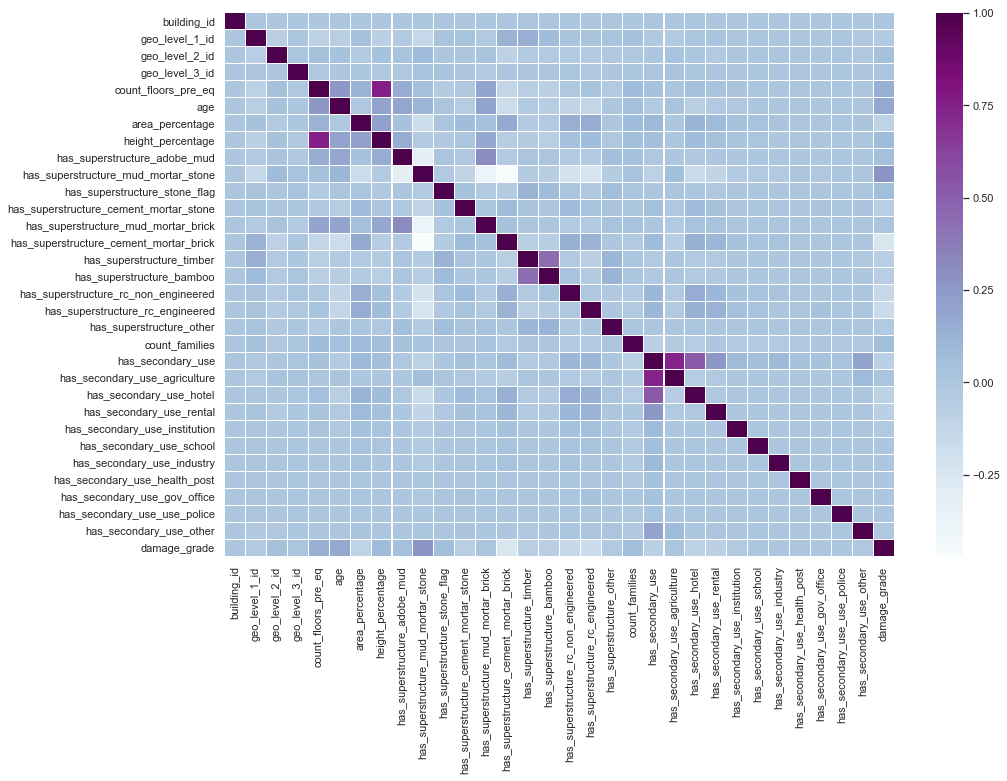

In [9]:
corrmat = df_train_vl.corr(method='spearman')
f,ax = plt.subplots(figsize=(15,10))
sns.heatmap(corrmat,ax=ax,cmap="BuPu", linewidths=0.1)

# Prepare the dataset

In [10]:
df['land_surface_condition'] = df['land_surface_condition'].replace(to_replace=['t', 'n', 'o'], value=(list(range(0,3))))
df['foundation_type'] = df['foundation_type'].replace(to_replace=['r', 'w', 'u','i','h'], value=(list(range(0,5))))
df['roof_type'] = df['roof_type'].replace(to_replace=['n', 'q', 'x'], value=(list(range(0,3))))
df['ground_floor_type'] = df['ground_floor_type'].replace(to_replace=['f', 'x', 'v', 'z', 'm'],value=(list(range(0,5))))
df['other_floor_type'] = df['other_floor_type'].replace(to_replace=['q', 'x', 'j', 's'], value=(list(range(0,4))))
df['position'] = df['position'].replace(to_replace=['s', 't', 'j', 'o'], value=(list(range(0,4))))
df['plan_configuration'] = df['plan_configuration'].replace(to_replace=['d', 'q', 'u', 's', 'c', 'a', 'o', 'm', 'n', 'f'],
                                                            value=(list(range(0,10))))
df['legal_ownership_status'] = df['legal_ownership_status'].replace(to_replace=['v', 'a', 'w', 'r'],value=(list(range(0,4))))

In [11]:
df.drop(['geo_level_2_id', 'geo_level_3_id', 'has_secondary_use',
         'count_floors_pre_eq'],axis = 1, inplace = True) #delete the features which we will not use

In [12]:
cat_features = ['plan_configuration', 'legal_ownership_status', 
                'count_families', 'geo_level_1_id', 'land_surface_condition', 
                'foundation_type','position','height_percentage',
                'roof_type', 'ground_floor_type', 'other_floor_type', 'area_percentage',
                
                'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',
                'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 
                'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
                'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
                'has_superstructure_other',  'has_secondary_use_agriculture', 'has_secondary_use_hotel', 
         'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 
         'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 
         'has_secondary_use_use_police', 'has_secondary_use_other'] #categorical features
num_features = ['age'] #numerical features

In [14]:
X = df[[*num_features, *cat_features]] #data for machine learning procedure
y = df[:260601]['damage_grade'] #target features

Encoding categorical functions

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
ohe = OneHotEncoder(sparse=False)

In [14]:
encoded_features = pd.DataFrame(ohe.fit_transform(X[['plan_configuration', 
                                                      'legal_ownership_status','count_families','geo_level_1_id', 
                                                     'land_surface_condition', 'foundation_type','position',
                                                     'roof_type', 'ground_floor_type', 'other_floor_type', 
                                                     'area_percentage','height_percentage']]))


C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [15]:
geo_level_1_id_cols = [f'geo_level_1_id_{cat}' for cat in ohe.categories_[0]]

land_surface_condition_cols = [f'land_surface_condition_{cat}' for cat in ohe.categories_[1]]
foundation_type_cols = [f'foundation_type_{cat}' for cat in ohe.categories_[2]]
position_cols = [f'position_{cat}' for cat in ohe.categories_[3]]

roof_type_cols = [f'roof_type_{cat}' for cat in ohe.categories_[4]]
ground_floor_type_cols = [f'ground_floor_type_{cat}' for cat in ohe.categories_[5]]
other_floor_type_cols = [f'other_floor_type_{cat}' for cat in ohe.categories_[6]]
area_percentage_cols = [f'area_percentage_{cat}' for cat in ohe.categories_[7]]
plan_configuration_cols = [f'plan_configuration_type_{cat}' for cat in ohe.categories_[8]]
legal_ownership_status_cols = [f'legal_ownership_status_{cat}' for cat in ohe.categories_[9]]
count_families_cols = [f'count_families_{cat}' for cat in ohe.categories_[10]]
# count_floors_pre_eq_cols = [f'count_floors_pre_eq_{cat}' for cat in ohe.categories_[11]]
height_percentage_cols = [f'height_percentage_{cat}' for cat in ohe.categories_[11]]

In [16]:
dummy_cols_names = [*geo_level_1_id_cols, 
                    *land_surface_condition_cols, *foundation_type_cols, *position_cols, *roof_type_cols,
                    *ground_floor_type_cols, *other_floor_type_cols, *area_percentage_cols, 
                   *plan_configuration_cols, 
                    *legal_ownership_status_cols, *count_families_cols, *height_percentage_cols]

encoded_features.columns = dummy_cols_names

Delete old categorical features after encoding procedure

In [17]:
X.drop(['plan_configuration', 'legal_ownership_status', 'count_families','geo_level_1_id',
                                                     'land_surface_condition', 'foundation_type','position', 
                                                    'roof_type', 'ground_floor_type', 'other_floor_type',
        'height_percentage', 'area_percentage'], axis=1, inplace=True)

C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
X = pd.concat([X, encoded_features], axis = 1)

In [19]:
X_1 = X[:260601][:]
X_2 = X[260601:][:]
X_2.index = np.arange(len(X_2))

# Perform an exploratory analysis of the data

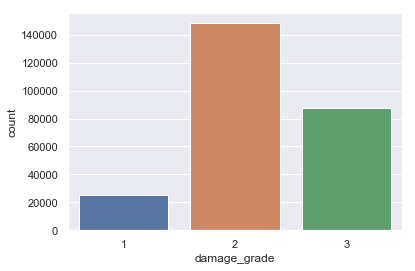

In [20]:
sns.countplot('damage_grade', data=df_train_vl);

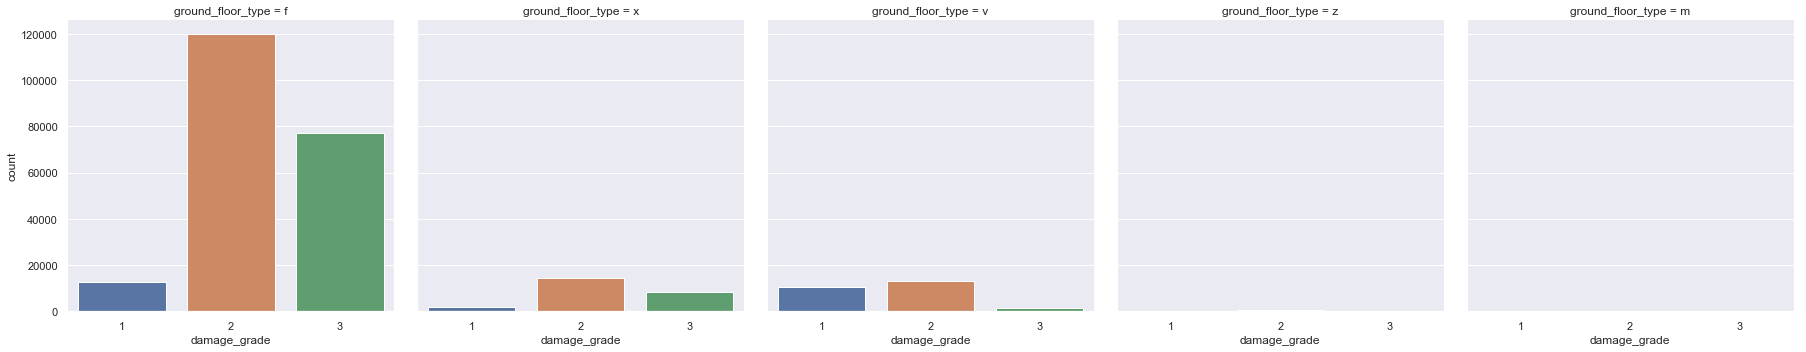

In [21]:
sns.catplot(x='damage_grade', col='ground_floor_type', kind='count', data=df_train_vl);

In [22]:
df_train_vl.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


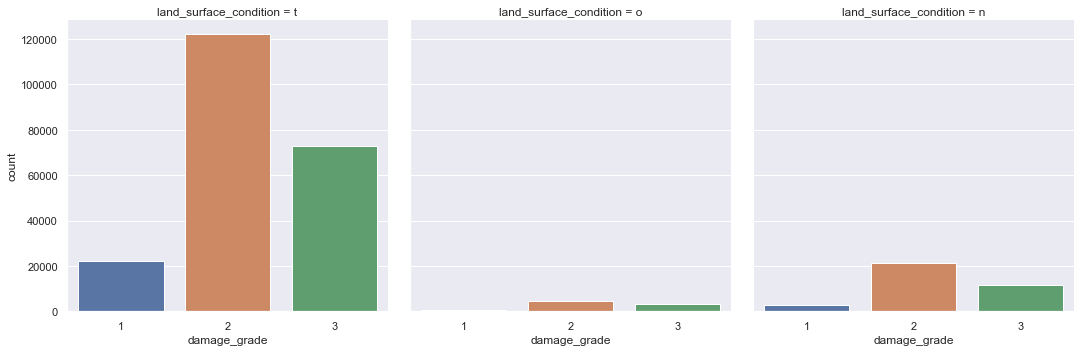

In [24]:
sns.catplot(x='damage_grade', col='land_surface_condition', kind='count', data=df_train_vl);

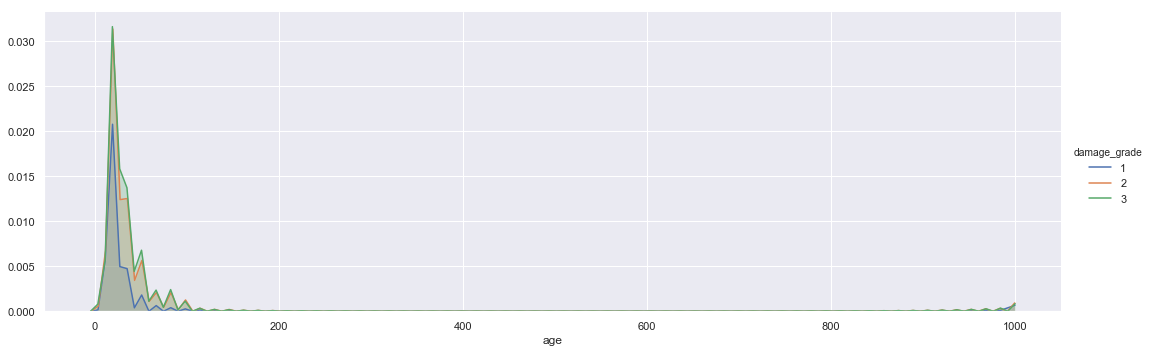

In [26]:
fig = sns.FacetGrid(df_train_vl, hue='damage_grade', height = 5, aspect = 3)
fig.map(sns.kdeplot, 'age',shade=True)
fig.add_legend();

# Feature selection

In [27]:
selector = SelectKBest(k = 120)
selector.fit(X_1, y)
print(X.shape)
X_1_reduced = selector.transform(X_1)
print(X_1_reduced.shape)

C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [177 184 207 213] are constant.
  UserWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(347469, 216)
(260601, 120)


In [28]:
indices = np.argsort(selector.scores_)[::-1]

(-1, 216)

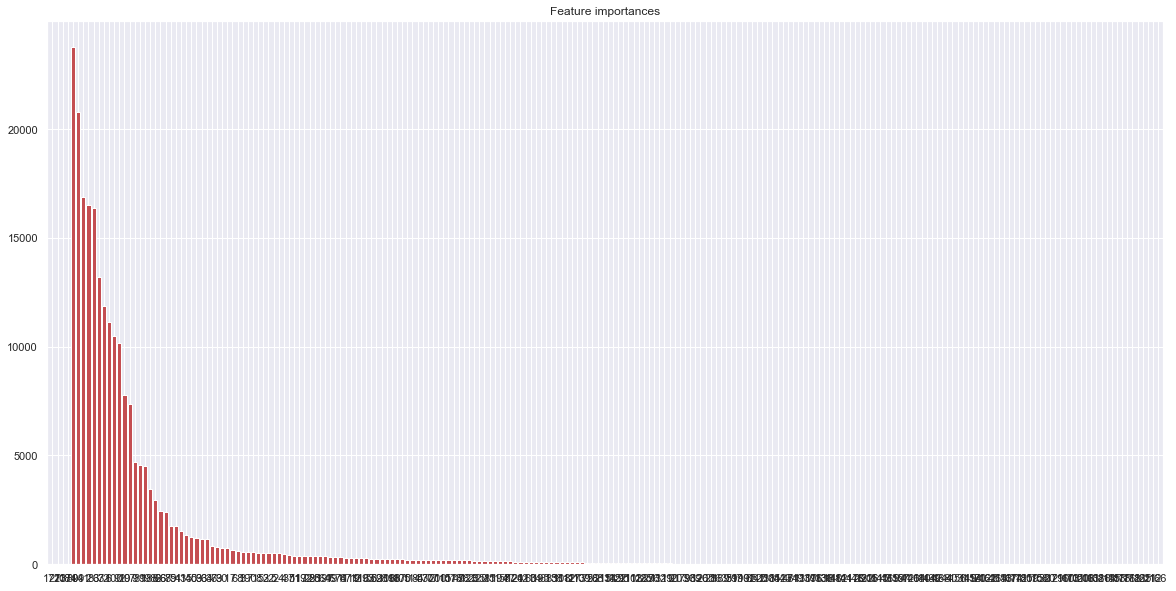

In [31]:
plt.figure(figsize = (20,10))
plt.title("Feature importances")
plt.bar(range(X_1.shape[1]),selector.scores_[indices],
       color="r", align="center")
plt.xticks(range(X_1.shape[1]),indices)
plt.xlim([-1, X_1.shape[1]])

In [26]:
cv_scores = cross_val_score(LogisticRegression(), X_1_reduced, y)

print('CV scores are {:.3f} +- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be c

CV scores are 0.670 +- 0.001


In [27]:
cv_scores = cross_val_score(xgb.XGBClassifier(), X_1, y)
print('CV scores are {:.3f} +- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CV scores are 0.672 +- 0.001


# Build a proper cross-validation procedure

Logistic Regression

In [28]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)
clf = LogisticRegression()

cv_scores = cross_val_score(clf, X_1, y, cv=cv)

print('CV scores are {:.3f} +- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silenc

CV scores are 0.670 +- 0.002


Random Forest

In [29]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)
clf = RandomForestClassifier()

cv_scores = cross_val_score(clf, X_1, y, cv=cv)

print('CV scores are {:.3f} +- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in vers

CV scores are 0.657 +- 0.002


K Neighbors

In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)
clf = KNeighborsClassifier(5)

cv_scores = cross_val_score(clf, X_1, y, cv=cv)

print('CV scores are {:.3f} +- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

CV scores are 0.630 +- 0.002


XG boost

In [31]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)
clf = xgb.XGBClassifier()

cv_scores = cross_val_score(clf, X_1, y, cv=cv)

print('CV scores are {:.3f} +- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

CV scores are 0.672 +- 0.002


#  Split the dataset

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=42, stratify = y)

Numerical data normalization

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

# ML

GridSearch

In [27]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Parameter Tuning
model = xgb.XGBClassifier()
param_dist = {"max_depth": range(8,15),
              "n_estimators":[100, 200, 300, 350],
             }
grid_search = GridSearchCV(model, param_grid=param_dist, 
                                   verbose = 1, n_jobs = -1, cv=cv)
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too s


C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\EKATER~1.KUZ\AppData\Local\Temp\joblib_memmapping_folder_10544_9957850205 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))
C:\Users\Ekaterina.Kuznetsova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\disk.py:122: UserWarning: Unable to delete folder C:\Users\EKATER~1.KUZ\AppData\Local\Temp\joblib_memmapping_folder_10544_9957850205 after 5 tentatives.
  .format(folder_path, RM_SUBDIRS_N_RETRY))


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\EKATER~1.KUZ\\AppData\\Local\\Temp\\joblib_memmapping_folder_10544_9957850205\\10544-2595238216480-5b4644f9c6674a5193320749c06bb285.pkl'

In [ ]:
grid_search.cv_results_

In [ ]:
grid_search.best_score_

XGBClassifier

In [28]:
model = xgb.XGBClassifier(max_depth = 15, n_estimators=200)

In [29]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [30]:
y_pred = model.predict(X_test)

In [33]:
f1_score(y_test,y_pred, average = 'micro') #final accuracy 

0.700907503693329

In [35]:
y_pred_test = model.predict(X_2)

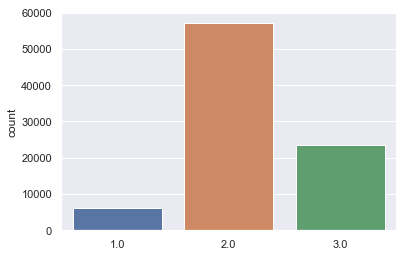

In [42]:
sns.countplot(y_pred_test);